# ISEL - CPS 
## Semestre 2022/23
# <br>
###  <center> Trabalho Prático 2 Parte B </center>
# </br>


Trabalho realizado por:
* Bárbara Jesus, numero <b> 45108 </b>
* João Fernandes, numero <b> 47478 </b>
* Duarte Afonso, numero <b> 47736 </b>

<b> Turma L33D - Docente Michele Mengucci</b>

In [173]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import scipy.signal as scisig

In [174]:
path_sons = './sons/questao1/'
file = 'fonte_mov.wav'
Fs, data = wav.read(path_sons + file)

In [175]:
def getAudioAng(som, Fs):
    canal_L = np.asarray(som[:, 0], dtype = np.int64)
    canal_R = np.asarray(som[:, 1], dtype = np.int64)
    # Correlação entre os dois canais de audio (esquerdo e direito)
    correlacao = scisig.correlate(canal_L, canal_R, mode = 'full')
    # Delay entre os dois canais de audio (samples)
    atrasoSamples = np.argmax(correlacao) - len(canal_L) + 1
    # Delay entre os dois canais de audio (segundos)
    atrasoSec = atrasoSamples / Fs
    # Velocidade do som
    c = 343
    # Distância entre ouvidos
    d = 0.18
    # Ângulo estimado da fonte sonora
    teta_rad = np.arcsin(atrasoSec * c / d)
    teta_degrees = teta_rad / np.pi * 180
    return teta_rad, teta_degrees

C:\Users\JCMF2\AppData\Local\Temp\ipykernel_27612\4012677187.py:15: RuntimeWarning: invalid value encountered in arcsin
  teta_rad = np.arcsin(atrasoSec * c / d)


(-1.4, 1.4, -1.2, 1.2)

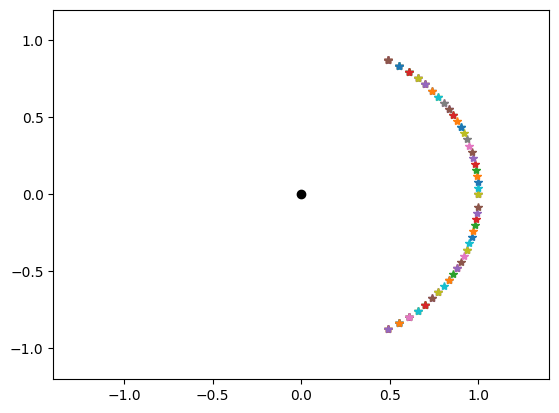

In [176]:
tempSegmento = .25
samplesSegmento = Fs * tempSegmento

angs = np.empty
coorX = np.empty
coorY = np.empty

# Distância à fonte sonora
D = 1

for i in np.arange(0, len(data[:, 0]) / samplesSegmento):
    sample_L = data[int(i*samplesSegmento):int((i+1)*samplesSegmento), 0]
    sample_R = data[int(i*samplesSegmento):int((i+1)*samplesSegmento), 1]
    sample = np.array([sample_L, sample_R])
    
    ang_rad_sample = getAudioAng(sample.T, Fs)[0]
    angs = np.append(angs, ang_rad_sample)
    coorX = np.append(coorX, D * np.cos(ang_rad_sample))
    coorY = np.append(coorY, D * np.sin(ang_rad_sample))
    
angs = angs[1:]
coorX = coorX[1:]
coorY = coorY[1:]

for i in range(len(coorX)):
    plt.plot(coorX[i], coorY[i], '*')
plt.plot(0, 0, 'ok')
plt.axis([-1.4, 1.4, -1.2, 1.2])

# Questão 2


In [177]:
path_sons = './sons/questao1/'
file = 'binaural_ITD_c_Questao1.wav'
Fs, data = wav.read(path_sons + file)

In [178]:
campo_direto = data[:, 0]

In [179]:
def campoReverb_Total(RT60, som, Fs):

    if RT60 == 0:
        return np.zeros(Fs), som
    
    n = np.arange(0, 1*Fs)
    C = 3*np.log(10/RT60)
    beta = np.random.randn(len(n))
    
    # Room Impulse Response
    RIR = beta * np.exp(-C/Fs*n)
    RIR = RIR/np.max(np.abs(RIR)) # normaliza a 1
    campo_reverb = RIR*2**(15-1) # normaliza a int16
    
    campo_total = np.convolve(np.asarray(som, dtype=np.int32), np.asarray(campo_reverb[6000:], dtype=np.int32))
    campo_total = campo_total/(2**18)
    
    return campo_reverb, campo_total

In [180]:
RT60 = .5
som = campo_direto

campo_reverb0, campo_total0 = campoReverb_Total(0, campo_direto, Fs)
campo_reverb5, campo_total5 = campoReverb_Total(.5, campo_direto, Fs)
campo_reverb2, campo_total2 = campoReverb_Total(2, campo_direto, Fs)
campo_reverb10, campo_total10 = campoReverb_Total(10, campo_direto, Fs)

In [181]:
wav.write('./sons/questao2/campo_direto.wav', Fs, campo_direto.astype(np.int16))
wav.write('./sons/questao2/campo_reverb0.wav', Fs, campo_reverb0.astype(np.int16))
wav.write('./sons/questao2/campo_total0.wav', Fs, campo_total0.astype(np.int16))
wav.write('./sons/questao2/campo_reverb.5.wav', Fs, campo_reverb5.astype(np.int16))
wav.write('./sons/questao2/campo_total.5.wav', Fs, campo_total5.astype(np.int16))
wav.write('./sons/questao2/campo_reverb2.wav', Fs, campo_reverb2.astype(np.int16))
wav.write('./sons/questao2/campo_total2.wav', Fs, campo_total2.astype(np.int16))
wav.write('./sons/questao2/campo_reverb10.wav', Fs, campo_reverb10.astype(np.int16))
wav.write('./sons/questao2/campo_total10.wav', Fs, campo_total10.astype(np.int16))

# Questão 3

In [182]:
path_orquestra = './sons/orquestra/'
file = '01_Kick.wav'
Fs, data = wav.read(path_orquestra + file)
data.shape

C:\Users\JCMF2\AppData\Local\Temp\ipykernel_27612\1195586030.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, data = wav.read(path_orquestra + file)


(735745,)

In [183]:
# Função que muda a direção de uma fonte sonora de acordo com o ângulo pretendido.
# O som passado como argumento deve ser monaural e do tipo int32
# O ângulo passado deve estar entre -pi e pi (positivo para o lado esquerdo e negativo para o lado direito)
# Modos:
# direct - o som vai direto da fonte ao ouvido
# around - o som contorna a cabeça antes de chegar ao ouvido
def changeAudioSourcePos(som, Fs, angle, mode = 'direct'):
    
    # Velocidade do som
    c = 343
    # Distância entre ouvidos
    d = 0.18
    
    # Delay entre canais quando o som passa direto da fonte ao ouvido
    delay = d * np.sin(angle) / c
    if mode == 'around':
        # Delay entre canais quando o som contorna a cabeça antes de chegar ao ouvido
        delay = (d/2) * (angle + np.sin(angle)) / c

    # Delay entre canais (em amostras)
    delaySamples = abs(int(delay * Fs))
    
    canal_0 = som
    canal_1 = som
    
    for i in range(delaySamples):
        canal_0 = np.append(canal_0, 0)
        canal_1 = np.insert(canal_1, 0, 0)
    
    # Normalizar a 16 bits
    canal_0 = canal_0/(2**16)
    canal_1 = canal_1/(2**16)
    
    # Distinguir esquerda e direita
    if angle <= 0:
        result = np.array((canal_1.astype(np.int16), canal_0.astype(np.int16)))
    else:
        result = np.array((canal_0.astype(np.int16), canal_1.astype(np.int16)))
    return result.T

def changeAngHRTF(som, angle):
    path_HRTF = './HRTF/elev0/'
    HRTFname = 'H0e'+ '0' + str(abs(angle)) + 'a.wav'
    if abs(angle) < 10:
        HRTFname = 'H0e'+ '00' + str(abs(angle)) + 'a.wav'
    if abs(angle) > 99:
        HRTFname = 'H0e' + str(abs(angle)) + 'a.wav'
    Fs, hrtf = wav.read(path_HRTF + HRTFname)
    
    som = np.asarray(som, dtype=np.int32)
    hrtf = np.asarray(hrtf, dtype=np.int32)
    
    canal0 = np.convolve(som, hrtf[:, 0])
    canal1 = np.convolve(som, hrtf[:, 1])
    
    result = np.empty((2, len(canal0)), dtype = np.int32)
    
    if angle >= 0:
        result[0] = canal0 / (2**15)
        result[1] = canal1 / (2**15)
    else:
        result[1] = canal0 / (2**15)
        result[0] = canal1 / (2**15)
    
    return result.T
    
import os    

def getAudioData():
    
    path_orquestra = './sons/orquestra/'
    dataArr = []

    for i in os.listdir(path_orquestra):
        Fs, data = wav.read(path_orquestra + i)
        dataArr.append(data)
        
    return np.array(dataArr)

In [184]:
angles = [0, 45, 90, 135, -45, -90, -180]
audios = getAudioData()

for i in range(len(angles)):
    destination = './sons/questao3/' + str(i+1) + '_' + str(angles[i]) + '.wav'
    audio = changeAudioSourcePos(audios[i], 48000, np.deg2rad(angles[i]))
    wav.write(destination, 48000, audio)
    
for i in range(len(angles)):
    destination = './sons/questao3/' + str(i+1) + '_a' + str(angles[i]) + '.wav'
    audio = changeAudioSourcePos(audios[i], 48000, np.deg2rad(angles[i]), mode = 'around')
    wav.write(destination, 48000, audio)
    
angles = [0, 45, 90, 135, -90, -135, 180]    

for i in range(len(angles)):
    destination = './sons/questao3/hrtf/hrtf' + str(i+1) + '_' + str(angles[i]) + '.wav'
    som = audios[i]
    result = changeAngHRTF(som/(2**15), angles[i])
    wav.write('./sons/questao3/hrtf/' + str(i+1) + 'hrtf' + str(angles[i]) + '.wav', 48000, result.astype(np.int16))

C:\Users\JCMF2\AppData\Local\Temp\ipykernel_27612\3210011502.py:75: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, data = wav.read(path_orquestra + i)


In [185]:
def campoReverbBinaural(RT60, som, Fs):

    if RT60 == 0:
        return som
    
    som = som.astype(np.int32)
    
    n = np.arange(0, 1*Fs)
    C = 3*np.log(10/RT60)
    beta = np.random.randn(len(n))
    
    # Room Impulse Response
    xRIR = beta * np.exp(-C/Fs*n) 

    xRIR = xRIR/np.max(np.abs(xRIR)) # normaliza a 1
    xRIR = xRIR*2**(15-1) # normaliza a int16

    xRIR = np.asarray(xRIR, dtype=np.int32)

    canal0 = np.convolve(xRIR[6000:], som[:, 0])
    canal1 = np.convolve(xRIR[6000:], som[:, 1])
    
    campo_reverb = np.empty((2, len(canal0)), dtype=np.int32)

    campo_reverb[0] = canal0/(2**15) #Tem que se dividir por metade da gama dinâmica para depois se converter para 16 bits (int16)
    campo_reverb[1] = canal1/(2**15)

    campo_total = campo_reverb.T
    
    return campo_total

In [186]:
pathHRTF = './sons/questao3/hrtf/'
som = wav.read(pathHRTF + '2hrtf45.wav')[1]
RT60 = 10
result = campoReverbBinaural(RT60, som, 44100)
wav.write(pathHRTF + 'rev' + str(RT60) + '.wav',  48000, result.astype(np.int16))

In [187]:
pathHRTF = './HRTF/elev0/'
angles = [45, 135, -45, -135]
kick = wav.read('./sons/orquestra/01_Kick.wav')
for i in range(len(angles)):
    wav.write('./sons/questao3/hrtf/teste' + str(angles[i]) + '.wav', 48000, changeAngHRTF(kick[1]/(2**15), angles[i]).astype(np.int16))

C:\Users\JCMF2\AppData\Local\Temp\ipykernel_27612\3318617632.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  kick = wav.read('./sons/orquestra/01_Kick.wav')


In [189]:
def circularSound(som, starting_angle ,audio_per_round):
    
    # Número de amostras por ângulo (37 é o número de ficheiros HRTF / ângulos possiveis em meia volta)
    # 72 = (36 - 1) * 2 para não repetir um ângulo numa volta completa
    samples_per_angle = int(len(som)/(audio_per_round * 72))
    
    # Garantir que o ângulo é multiplo de 5
    angle = starting_angle
    result = np.empty((2, len(som)), dtype=np.int32)
    
    for i in range(0, len(som), samples_per_angle):
        soundSlice = changeAngHRTF(som[i:i+samples_per_angle], angle)
        
        if len(result[0][i:i+len(soundSlice)]) < len(soundSlice[:, 0]):
            break
        
        result[0][i:i+len(soundSlice)] = soundSlice[:, 0]
        result[1][i:i+len(soundSlice)] = soundSlice[:, 1]
            
        angle += 5
        if angle == 180:
            angle = -180
            
    return result

C:\Users\JCMF2\AppData\Local\Temp\ipykernel_27612\3257354022.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, som = wav.read(pathOrq + '01_Kick.wav')


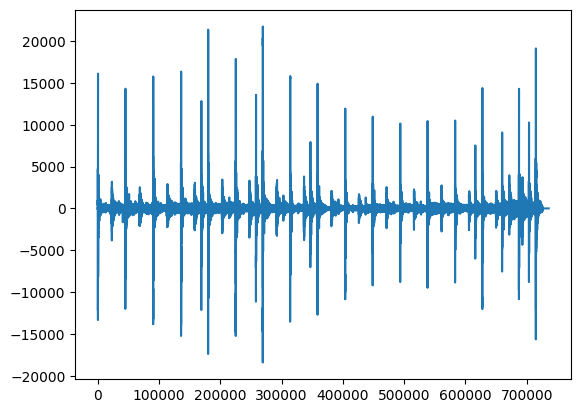

In [203]:
pathOrq = './sons/orquestra/'
fs, som = wav.read(pathOrq + '01_Kick.wav')
around = circularSound(som/(2**15), 0, 1).astype(np.int16)
plt.plot(around[1])
wav.write('./sons/questao4/around.wav', 48000, around.T)